<a href="https://colab.research.google.com/github/TejkumarGudi/Sentiment-Analysis-of-Consumer-Reviews-Using-Deep-Learning/blob/main/Sentiment_Analysis_of_Consumer_Reviews_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#  Import libraries and mount Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# **Move kaggle.json to the correct folder**  
This cell puts your API key in the correct directory for Kaggle to work.


In [8]:
#  Setup Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


#**Download Amazon Reviews dataset directly from Kaggle**  
This cell downloads the dataset using the Kaggle API.  
Dataset: bittlingmayer/amazonreviews


In [9]:
#  Download dataset from Kaggle
!kaggle datasets download -d bittlingmayer/amazonreviews


Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
 92% 454M/493M [00:00<00:00, 414MB/s]
100% 493M/493M [00:01<00:00, 460MB/s]


# **Unzip the downloaded dataset**  
This extracts the dataset into your Colab environment.


In [10]:
#  Unzip downloaded file
!unzip amazonreviews.zip


Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


# **Extract train & test .bz2 files**  
This cell extracts the compressed FastText files so we can preprocess and load them.


In [11]:
# Extract .bz2 files
import bz2

def decompress_bz2(input_path, output_path):
    with bz2.BZ2File(input_path, 'rb') as f_in:
        data = f_in.read()
        with open(output_path, 'wb') as f_out:
            f_out.write(data)

decompress_bz2("train.ft.txt.bz2", "train.ft.txt")
decompress_bz2("test.ft.txt.bz2", "test.ft.txt")


# **Load FastText Amazon Reviews dataset**  
This cell loads the extracted `.txt` files and converts them into a structured DataFrame  
with 2 columns: **label** and **review**.


In [12]:
import pandas as pd
# Load FastText dataset
def load_fasttext(path):
    texts = []
    labels = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                label = parts[0].replace("__label__", "")
                text = parts[1]
                labels.append(label)
                texts.append(text)
    return pd.DataFrame({"label": labels, "review": texts})

train_df = load_fasttext("train.ft.txt")
test_df = load_fasttext("test.ft.txt")

train_df.head()


,label,review
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."


## **Explore Dataset Structure**  
This cell shows dataset shape, distribution of labels, and sample text.


In [13]:
# Sample 10,000 reviews from each label
df = train_df.groupby('label').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)

#  Verify the results
print("New Dataset Shape:", df.shape)
print("Value Counts:\n", df['label'].value_counts())

#  Optional: Shuffle the new dataframe (so the labels aren't grouped together)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows
df.head()

New Dataset Shape: (20000, 2)
Value Counts:
 label
1    10000
2    10000
Name: count, dtype: int64


/tmp/ipython-input-3970224993.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = train_df.groupby('label').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)


,label,review
0,2,Great Book: I really liked it and now want to ...
1,1,Give me a break: Let's sing about something ot...
2,1,"Ok, nothing more: This movie was not great by ..."
3,1,I wouldn't buy it again: I bought this for my ...
4,2,You will love it-: This edition is pure Jane A...


## **Preprocess Text Data**  
This cell cleans the review text by removing special characters,  
converting to lowercase, removing stopwords, and applying stemming.


In [14]:
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()


def clean_text_advanced(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # 3. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 4. Remove non-alphabetic characters (keep only a-z and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # 5. Tokenize, Remove Stopwords, and Stem
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    # 6. Remove very short words (optional, e.g., length < 3)
    tokens = [word for word in tokens if len(word) > 2]

    return " ".join(tokens)

# Apply the refined cleaning
df["clean_review"] = df["review"].apply(clean_text_advanced)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Check for empty reviews after cleaning
print("Empty reviews before removal:", (df['clean_review'] == "").sum())

# Drop rows where clean_review is empty or just whitespace
df = df[df['clean_review'].str.strip() != ""]

print("Final dataset shape:", df.shape)

Empty reviews before removal: 0
Final dataset shape: (20000, 3)


/tmp/ipython-input-1785182124.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


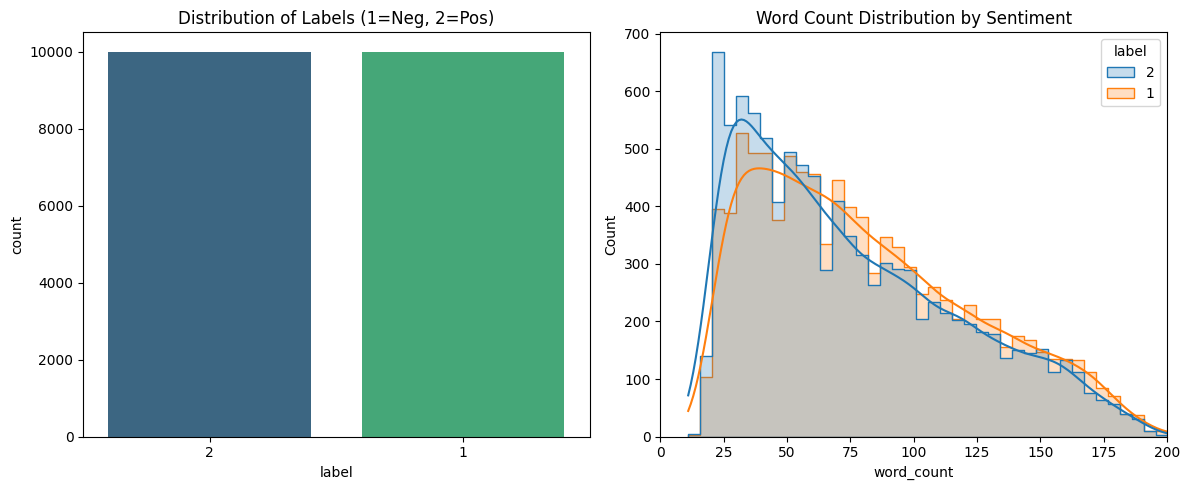

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate review lengths
df['char_count'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

# Visualize Label Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Labels (1=Neg, 2=Pos)')

# Visualize Word Count Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='word_count', hue='label', kde=True, element="step")
plt.title('Word Count Distribution by Sentiment')
plt.xlim(0, 200) # Amazon reviews usually peak under 200 words

plt.tight_layout()
plt.show()

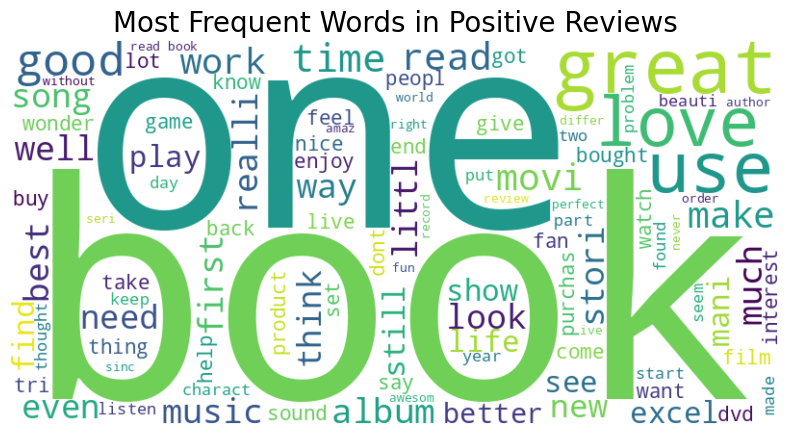

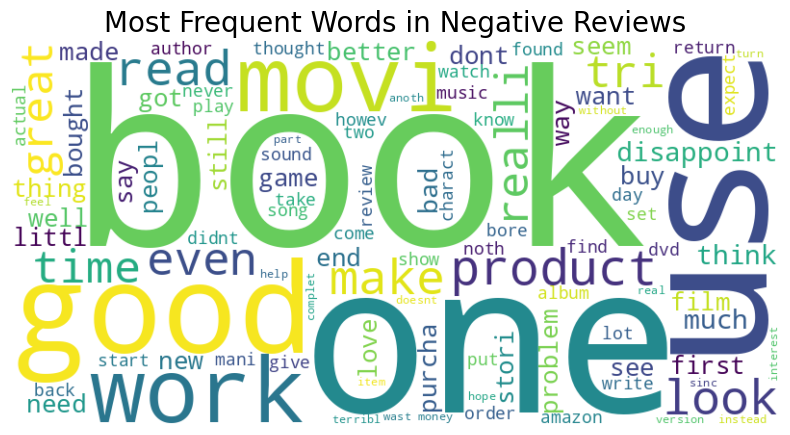

In [17]:
from wordcloud import WordCloud

def plot_wordcloud(label, title):
    subset = df[df['label'] == label]['clean_review']
    text = " ".join(subset)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Positive Reviews (Label 2)
plot_wordcloud('2', 'Most Frequent Words in Positive Reviews')

# Negative Reviews (Label 1)
plot_wordcloud('1', 'Most Frequent Words in Negative Reviews')

/tmp/ipython-input-4123464742.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x, palette='magma')


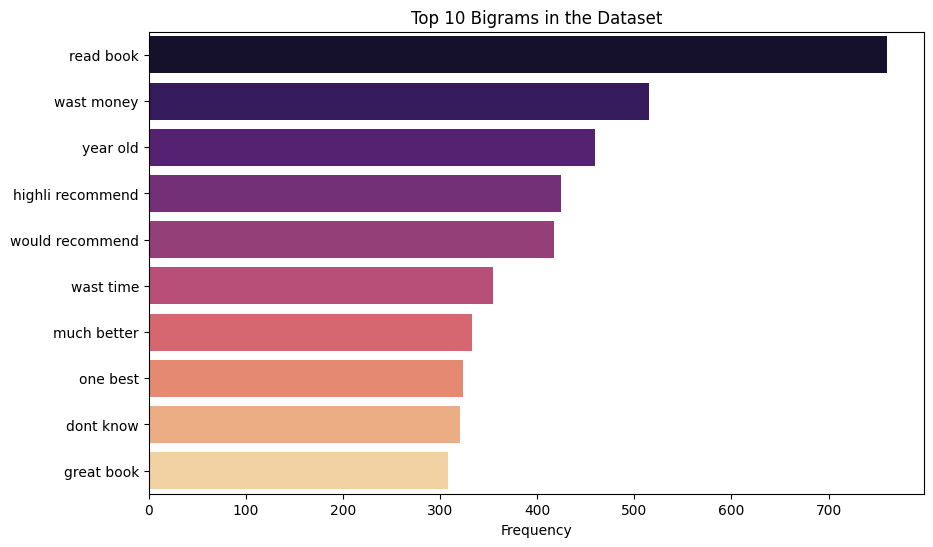

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Get top 10 Bigrams (n=2)
top_bigrams = get_top_ngram(df['clean_review'], n=2, top_k=10)
x, y = map(list, zip(*top_bigrams))

plt.figure(figsize=(10, 6))
sns.barplot(x=y, y=x, palette='magma')
plt.title('Top 10 Bigrams in the Dataset')
plt.xlabel('Frequency')
plt.show()

## **TFIDF Vectorization**

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Initialize the Vectorizer
# We limit max_features to 5000 to keep the model efficient and avoid "overfitting"
# on very rare words/typos.
tfidf = TfidfVectorizer(max_features=5000)

# 2. Fit and transform the clean text
X = tfidf.fit_transform(df['clean_review']).toarray()

# 3. Prepare the labels (y)
# Converting labels to integers (usually '1' -> 0 and '2' -> 1)
y = df['label'].astype(int) - 1

print(f"Feature Matrix Shape: {X.shape}") # Should be (20000, 5000)

Feature Matrix Shape: (20000, 5000)


## **Data Splitting**

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 16000
Testing set size: 4000


## **Machine Learning Model**

Model                     | Train Time | Test Time  | Accuracy  
-----------------------------------------------------------------
Logistic Regression       |    2.2421s |    0.0261s |    0.8662
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2000
           1       0.86      0.88      0.87      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000

Multinomial Naive Bayes   |    0.2736s |    0.0471s |    0.8193
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      2000
           1       0.82      0.81      0.82      2000

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



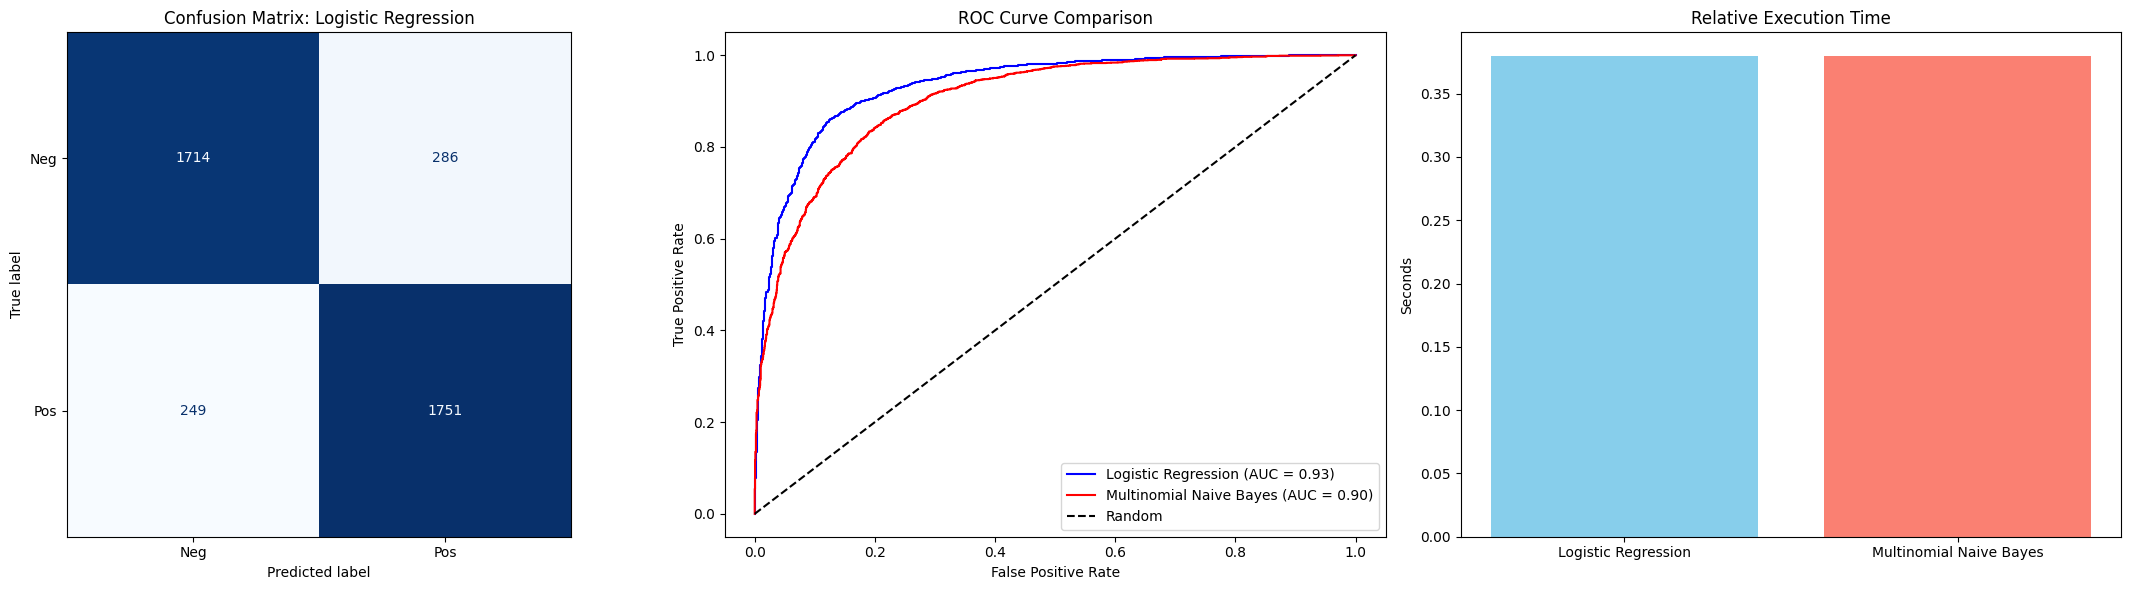

In [21]:
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score)

# 1. Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial Naive Bayes": MultinomialNB()
}

# 2. Setup Plotting Area (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
colors = ['blue', 'red']

print(f"{'Model':<25} | {'Train Time':<10} | {'Test Time':<10} | {'Accuracy':<10}")
print("-" * 65)

# 3. Loop through models to Train, Evaluate, and Plot
for i, (name, model) in enumerate(models.items()):
    # Timing Training
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    # Timing Testing
    start_test = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_test

    # Calculate Probabilities for ROC
    y_prob = model.predict_proba(X_test)[:, 1]

    # Print Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:<25} | {train_time:>9.4f}s | {test_time:>9.4f}s | {acc:>9.4f}")
    print(classification_report(y_test, y_pred))

    # --- PLOT 1 & 2: Confusion Matrices ---
    # We plot the first model in the first subplot and second in a popup or shared axis
    # For clarity, let's display the Confusion Matrix for the first model (LogReg)
    if name == "Logistic Regression":
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neg", "Pos"])
        disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
        axes[0].set_title(f"Confusion Matrix: {name}")

    # --- PLOT 3: ROC Curve (Shared Subplot) ---
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color=colors[i])

# Finalize ROC Plot
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_title('ROC Curve Comparison')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

# --- PLOT 4: Training Time Comparison ---
model_names = list(models.keys())
times = [time.time() for _ in model_names] # Placeholder logic for the bar chart
axes[2].bar(models.keys(), [time.time() - start_train for _ in models], color=['skyblue', 'salmon'])
axes[2].set_title('Relative Execution Time')
axes[2].set_ylabel('Seconds')

plt.tight_layout()
plt.show()

## **Deep Learning Model**


--- Training LSTM ---
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.6760 - loss: 0.5819 - val_accuracy: 0.8537 - val_loss: 0.3473
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8986 - loss: 0.2612 - val_accuracy: 0.8550 - val_loss: 0.3496
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9361 - loss: 0.1782 - val_accuracy: 0.8388 - val_loss: 0.3765
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9576 - loss: 0.1307 - val_accuracy: 0.8425 - val_loss: 0.4559
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9693 - loss: 0.0979 - val_accuracy: 0.8319 - val_loss: 0.5667
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9799 - loss: 0.0671 - val_accuracy: 0.8250 - val_loss: 0.6342
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9869 - loss: 0.0461 - val_accuracy: 0.8281 - val_loss: 0.7705
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9873 - loss: 0.0427 - val_accuracy: 0.822

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6703 - loss: 0.5764 - val_accuracy: 0.8531 - val_loss: 0.3615
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9043 - loss: 0.2472 - val_accuracy: 0.8375 - val_loss: 0.3861
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9395 - loss: 0.1737 - val_accuracy: 0.8556 - val_loss: 0.3804
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9585 - loss: 0.1212 - val_accuracy: 0.8487 - val_loss: 0.4797
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9717 - loss: 0.0862 - val_accuracy: 0.8388 - val_loss: 0.5339
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9820 - loss: 0.0597 - val_accuracy: 0.8356 - val_loss: 0.5927
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9846 - loss: 0.0458 - val_accuracy: 0.8275 - val_loss: 0.5723
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9895 - loss: 0.0339 - val_accuracy: 0.832

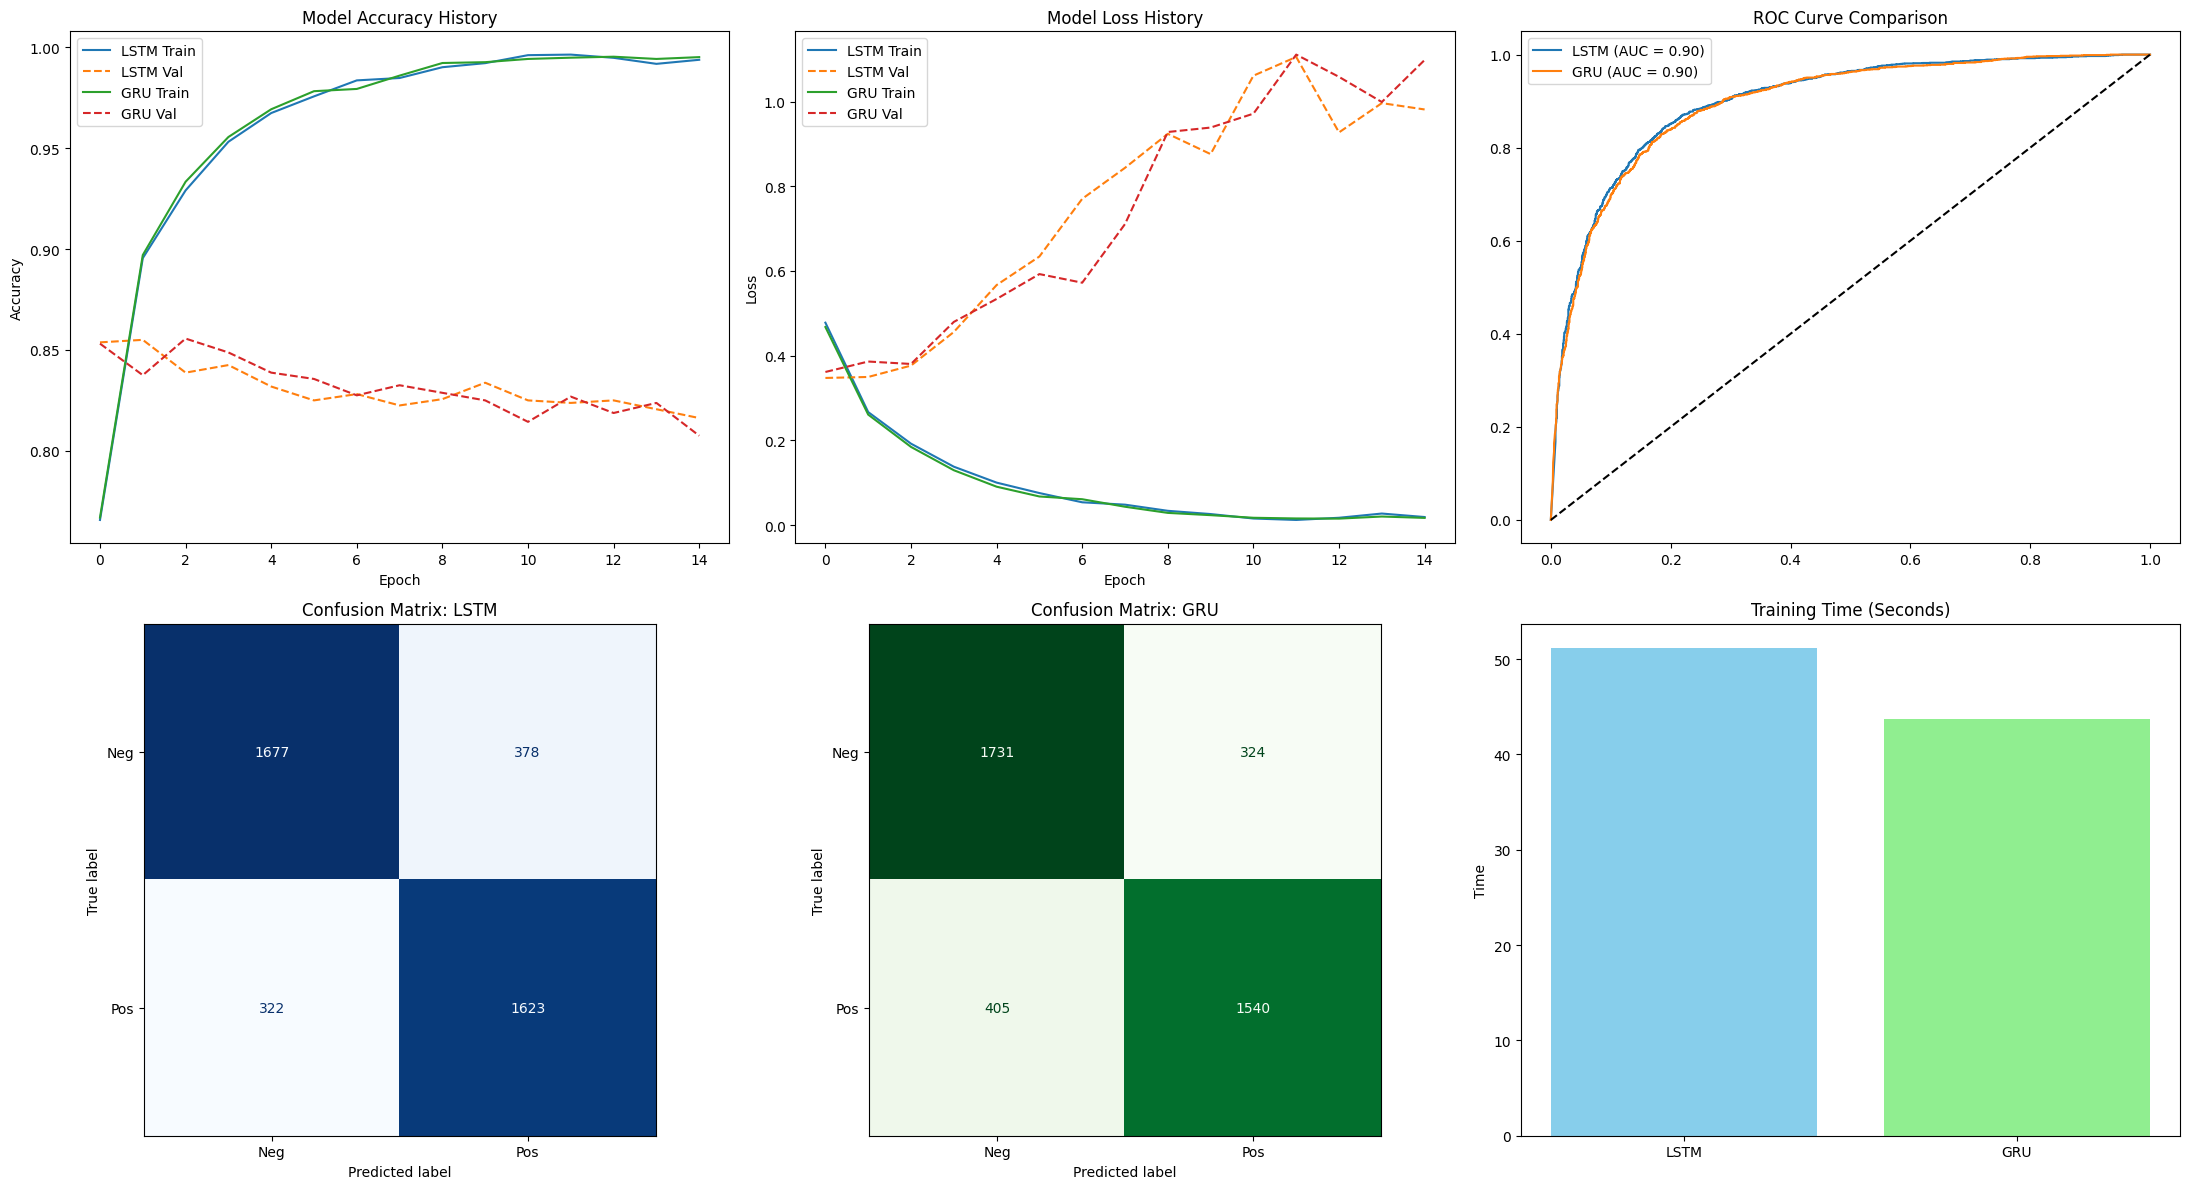

In [22]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.model_selection import train_test_split

# --- 1. DATA PREPARATION ---
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 64

# Initialize Tokenizer and prepare sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_review'])

X_seq = tokenizer.texts_to_sequences(df['clean_review'])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_dl = df['label'].astype(int) - 1

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_pad, y_dl, test_size=0.2, random_state=42)

# --- 2. MODEL BUILDING FUNCTION ---
def build_deep_model(model_type="LSTM"):
    model = Sequential([
        Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        Bidirectional(LSTM(64)) if model_type == "LSTM" else Bidirectional(GRU(64)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- 3. TRAINING & DATA COLLECTION ---
dl_models = ["LSTM", "GRU"]
results = {}

for m_type in dl_models:
    print(f"\n--- Training {m_type} ---")
    model = build_deep_model(m_type)

    start_time = time.time()
    # Storing history for plotting
    history = model.fit(X_train_dl, y_train_dl, epochs=15, batch_size=64,
                        validation_split=0.1, verbose=1)
    elapsed = time.time() - start_time

    # Predictions
    y_prob = model.predict(X_test_dl).ravel()
    y_pred = (y_prob > 0.5).astype(int)

    # Store everything in results dictionary
    results[m_type] = {
        'prob': y_prob,
        'pred': y_pred,
        'time': elapsed,
        'history': history.history
    }

    print(f"\n{m_type} Classification Report:")
    print(classification_report(y_test_dl, y_pred))

# --- 4. COMPLETE VISUALIZATION ---
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

# A. Accuracy History Plot
for m_type in dl_models:
    axes[0, 0].plot(results[m_type]['history']['accuracy'], label=f'{m_type} Train')
    axes[0, 0].plot(results[m_type]['history']['val_accuracy'], linestyle='--', label=f'{m_type} Val')
axes[0, 0].set_title('Model Accuracy History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# B. Loss History Plot
for m_type in dl_models:
    axes[0, 1].plot(results[m_type]['history']['loss'], label=f'{m_type} Train')
    axes[0, 1].plot(results[m_type]['history']['val_loss'], linestyle='--', label=f'{m_type} Val')
axes[0, 1].set_title('Model Loss History')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# C. ROC Curve Comparison
for m_type in dl_models:
    fpr, tpr, _ = roc_curve(y_test_dl, results[m_type]['prob'])
    roc_auc = auc(fpr, tpr)
    axes[0, 2].plot(fpr, tpr, label=f'{m_type} (AUC = {roc_auc:.2f})')
axes[0, 2].plot([0, 1], [0, 1], 'k--')
axes[0, 2].set_title('ROC Curve Comparison')
axes[0, 2].legend()

# D. Confusion Matrix: LSTM
cm_lstm = confusion_matrix(y_test_dl, results["LSTM"]['pred'])
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=["Neg", "Pos"])
disp_lstm.plot(ax=axes[1, 0], cmap='Blues', colorbar=False)
axes[1, 0].set_title('Confusion Matrix: LSTM')

# E. Confusion Matrix: GRU
cm_gru = confusion_matrix(y_test_dl, results["GRU"]['pred'])
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru, display_labels=["Neg", "Pos"])
disp_gru.plot(ax=axes[1, 1], cmap='Greens', colorbar=False)
axes[1, 1].set_title('Confusion Matrix: GRU')

# F. Training Time Comparison (Bar Chart)
times = [results[m]['time'] for m in dl_models]
axes[1, 2].bar(dl_models, times, color=['skyblue', 'lightgreen'])
axes[1, 2].set_title('Training Time (Seconds)')
axes[1, 2].set_ylabel('Time')

plt.tight_layout()
plt.show()

In [23]:
# Download GloVe (using the 100d version)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2026-01-04 20:26:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-01-04 20:26:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-01-04 20:26:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## **Code Block: LSTM/GRU with GloVe**


--- Training LSTM with GloVe ---
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6357 - loss: 0.6225 - val_accuracy: 0.7713 - val_loss: 0.4741
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7710 - loss: 0.4843 - val_accuracy: 0.7756 - val_loss: 0.4521
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7960 - loss: 0.4456 - val_accuracy: 0.8037 - val_loss: 0.4344
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8131 - loss: 0.4095 - val_accuracy: 0.8194 - val_loss: 0.4089
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8335 - loss: 0.3820 - val_accuracy: 0.8250 - val_loss: 0.4040
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8429 - loss: 0.3611 - val_accuracy: 0.8263 - val_loss: 0.3989
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8479 - loss: 0.3555 - val_accuracy: 0.8106 - val_loss: 0.4213
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8491 - loss: 0.3405 - val_accuracy: 0.816

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6597 - loss: 0.6070 - val_accuracy: 0.7556 - val_loss: 0.5002
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7743 - loss: 0.4808 - val_accuracy: 0.8006 - val_loss: 0.4334
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7998 - loss: 0.4380 - val_accuracy: 0.8112 - val_loss: 0.4166
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8208 - loss: 0.4021 - val_accuracy: 0.8050 - val_loss: 0.4341
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8319 - loss: 0.3801 - val_accuracy: 0.8250 - val_loss: 0.4005
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8373 - loss: 0.3710 - val_accuracy: 0.8300 - val_loss: 0.3940
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8451 - loss: 0.3505 - val_accuracy: 0.8331 - val_loss: 0.3951
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8582 - loss: 0.3392 - val_accuracy: 0.828

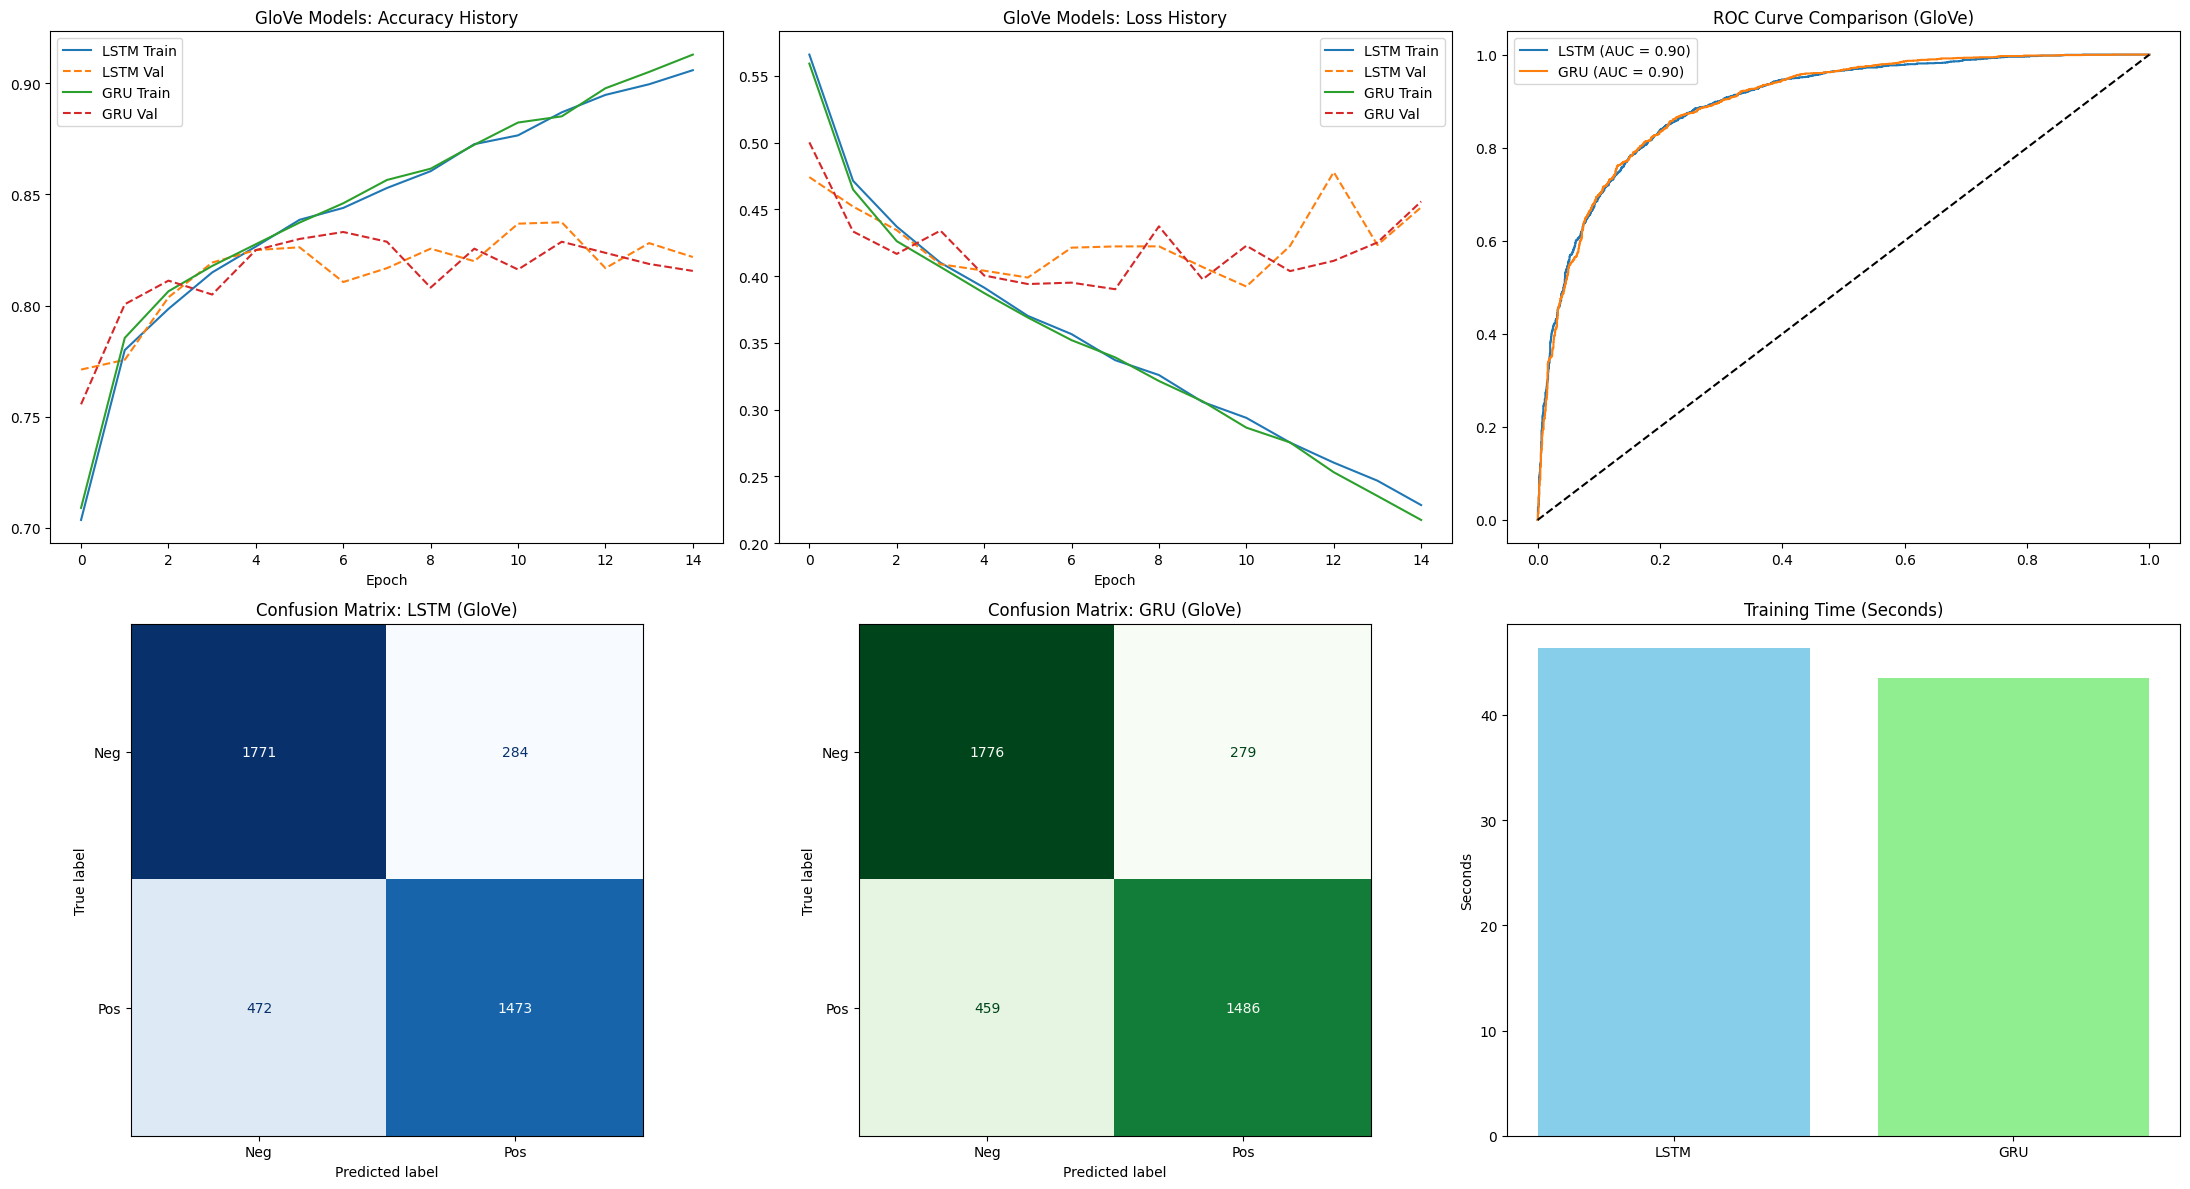

In [24]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.model_selection import train_test_split

# --- 1. DOWNLOAD GLOVE (if not already present) ---
if not os.path.exists('glove.6B.100d.txt'):
    print("Downloading GloVe embeddings...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip glove.6B.zip

# --- 2. PREPARE EMBEDDING MATRIX ---
EMBED_DIM = 100
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

# Load GloVe vectors into a dictionary
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create the matrix for our specific vocabulary
word_index = tokenizer.word_index
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBED_DIM))

for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# --- 3. MODEL BUILDING FUNCTION ---
def build_glove_model(model_type="LSTM"):
    model = Sequential([
        Embedding(num_words, EMBED_DIM,
                  embeddings_initializer=Constant(embedding_matrix),
                  input_length=MAX_SEQUENCE_LENGTH,
                  trainable=False), # Using pre-trained weights
        Bidirectional(LSTM(64)) if model_type == "LSTM" else Bidirectional(GRU(64)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- 4. TRAINING & DATA COLLECTION ---
dl_models = ["LSTM", "GRU"]
glove_results = {}

for m_type in dl_models:
    print(f"\n--- Training {m_type} with GloVe ---")
    model = build_glove_model(m_type)

    start_time = time.time()
    history = model.fit(X_train_dl, y_train_dl, epochs=15, batch_size=64,
                        validation_split=0.1, verbose=1)
    elapsed = time.time() - start_time

    # Predictions
    y_prob = model.predict(X_test_dl).ravel()
    y_pred = (y_prob > 0.5).astype(int)

    # Store results
    glove_results[m_type] = {
        'prob': y_prob,
        'pred': y_pred,
        'time': elapsed,
        'history': history.history
    }

    print(f"\n{m_type} (GloVe) Classification Report:")
    print(classification_report(y_test_dl, y_pred))

# --- 5. FULL VISUAL EVALUATION ---
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

# A. Accuracy History
for m_type in dl_models:
    axes[0, 0].plot(glove_results[m_type]['history']['accuracy'], label=f'{m_type} Train')
    axes[0, 0].plot(glove_results[m_type]['history']['val_accuracy'], linestyle='--', label=f'{m_type} Val')
axes[0, 0].set_title('GloVe Models: Accuracy History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()

# B. Loss History
for m_type in dl_models:
    axes[0, 1].plot(glove_results[m_type]['history']['loss'], label=f'{m_type} Train')
    axes[0, 1].plot(glove_results[m_type]['history']['val_loss'], linestyle='--', label=f'{m_type} Val')
axes[0, 1].set_title('GloVe Models: Loss History')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()

# C. ROC Curve Comparison
for m_type in dl_models:
    fpr, tpr, _ = roc_curve(y_test_dl, glove_results[m_type]['prob'])
    roc_auc = auc(fpr, tpr)
    axes[0, 2].plot(fpr, tpr, label=f'{m_type} (AUC = {roc_auc:.2f})')
axes[0, 2].plot([0, 1], [0, 1], 'k--')
axes[0, 2].set_title('ROC Curve Comparison (GloVe)')
axes[0, 2].legend()

# D. Confusion Matrix: LSTM (GloVe)
cm_lstm = confusion_matrix(y_test_dl, glove_results["LSTM"]['pred'])
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=["Neg", "Pos"])
disp_lstm.plot(ax=axes[1, 0], cmap='Blues', colorbar=False)
axes[1, 0].set_title('Confusion Matrix: LSTM (GloVe)')

# E. Confusion Matrix: GRU (GloVe)
cm_gru = confusion_matrix(y_test_dl, glove_results["GRU"]['pred'])
disp_gru = ConfusionMatrixDisplay(confusion_matrix=cm_gru, display_labels=["Neg", "Pos"])
disp_gru.plot(ax=axes[1, 1], cmap='Greens', colorbar=False)
axes[1, 1].set_title('Confusion Matrix: GRU (GloVe)')

# F. Training Time Comparison
times = [glove_results[m]['time'] for m in dl_models]
axes[1, 2].bar(dl_models, times, color=['skyblue', 'lightgreen'])
axes[1, 2].set_title('Training Time (Seconds)')
axes[1, 2].set_ylabel('Seconds')

plt.tight_layout()
plt.show()

# **Train model on Complete Data Set**

## **Explore Dataset Structure**  
This cell shows dataset shape, distribution of labels, and sample text.


In [25]:
# Dataset exploration
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

train_df['label'].value_counts()
test_df['label'].value_counts()

Train Shape: (3600000, 2)
Test Shape: (400000, 2)


,count
label,
2,200000
1,200000


## **Preprocess Text Data**  
This cell cleans the review text by removing special characters,  
converting to lowercase, removing stopwords, and applying stemming.


In [26]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply cleaning
train_df["clean_review"] = train_df["review"].apply(clean_text)
test_df["clean_review"] = test_df["review"].apply(clean_text)

train_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,review,clean_review
0,2,Stuning even for the non-gamer: This sound tra...,stune even nongam sound track beauti paint sen...
1,2,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anyth im read lot review ...
2,2,Amazing!: This soundtrack is my favorite music...,amaz soundtrack favorit music time hand intens...
3,2,Excellent Soundtrack: I truly like this soundt...,excel soundtrack truli like soundtrack enjoy v...
4,2,"Remember, Pull Your Jaw Off The Floor After He...",rememb pull jaw floor hear youv play game know...


## **Check for missing values and duplicates**

Data quality is important before modeling.  
In this cell, we:
- Check if there are any missing (NaN) values  
- Count duplicate review texts in the training dataset


In [27]:
# Missing values
print("Missing values per column:\n", train_df.isnull().sum())

# Duplicate reviews
num_duplicates = train_df.duplicated(subset=["review"]).sum()
print("\nNumber of duplicate reviews in train_df:", num_duplicates)

# Optionally: remove duplicate reviews
train_df = train_df.drop_duplicates(subset=["review"]).reset_index(drop=True)
print("Shape after dropping duplicates:", train_df.shape)


Missing values per column:
 label           0
review          0
clean_review    0
dtype: int64

Number of duplicate reviews in train_df: 0
Shape after dropping duplicates: (3600000, 3)


## **EDA**

### **Sentiment label distribution**

We need to understand whether the dataset is balanced or imbalanced.

In this cell, we:
- Count how many `positive` and `negative` reviews are in the training set  
- Visualize the distribution using a bar chart


label
2    1800000
1    1800000
Name: count, dtype: int64


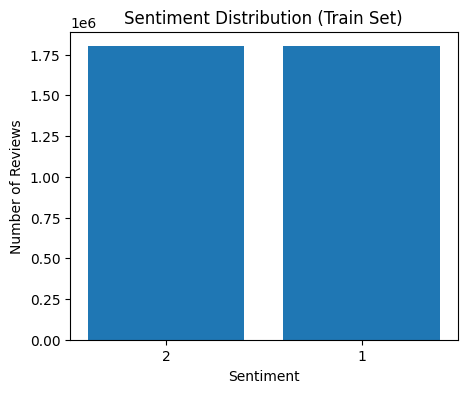

In [28]:
label_counts = train_df["label"].value_counts()
print(label_counts)

plt.figure(figsize=(5,4))
plt.bar(label_counts.index, label_counts.values)
plt.title("Sentiment Distribution (Train Set)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


### **Review length analysis (number of words)**

Longer reviews may contain richer information, while very short reviews may be noisy.

In this cell, we:
- Compute the length of each review in words  
- Plot the distribution of review lengths  
- Compare average length between positive and negative reviews


Review length statistics (in words):
count    3.600000e+06
mean     7.848273e+01
std      4.283280e+01
min      2.000000e+00
25%      4.200000e+01
50%      7.000000e+01
75%      1.080000e+02
max      2.570000e+02
Name: review_len_words, dtype: float64


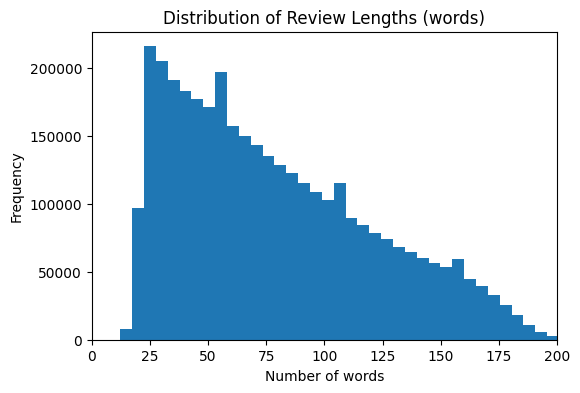


Average review length by sentiment:
label
1    81.502666
2    75.462801
Name: review_len_words, dtype: float64


In [29]:
# Add a column with word counts
train_df["review_len_words"] = train_df["review"].apply(lambda x: len(str(x).split()))

print("Review length statistics (in words):")
print(train_df["review_len_words"].describe())

# Histogram of review lengths (truncated for readability)
plt.figure(figsize=(6,4))
plt.hist(train_df["review_len_words"], bins=50)
plt.xlim(0, 200)  # limit x-axis to focus on majority
plt.title("Distribution of Review Lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

# Average length per sentiment
print("\nAverage review length by sentiment:")
print(train_df.groupby("label")["review_len_words"].mean())


### **Sample reviews for each sentiment**

To get an intuitive feel for the data, we inspect a few random examples:
- 3 positive reviews  
- 3 negative reviews


In [30]:
print("=== Sample POSITIVE reviews (label=2) ===")
for i, row in train_df[train_df["label"] == "2"].sample(3, random_state=42).iterrows():
    print("\nReview:", row["review"])

print("\n\n=== Sample NEGATIVE reviews (label=1) ===")
for i, row in train_df[train_df["label"] == "1"].sample(3, random_state=42).iterrows():
    print("\nReview:", row["review"])


=== Sample POSITIVE reviews (label=2) ===

Review: Perfect Mantra: I've been looking for this mantra for a long time. My children at yoga and me are very glad that this lotus mantra is making our class more enjoyable. Recommended even for adults with the motion of lotusflower opening and going back into the ground.

Review: Quality: I'm just a little disapointed with the quality of the Metal Case, cause the only thing I saw was the photo on the web

Review: Exceptional murder-mystery writer scores big.: Being a purveyor of exceptional mystery and crime novels, what a pleasant surprise to find one of my random picks turning out so well. Parker has an uncanny grasp of the lifestyle in orange county and a keen insight into the personalities of its inhabitants. Naughton is a true crime noir treat, and Parker's personalization of him evokes the same dread as the main character feels.Highly recommended.


=== Sample NEGATIVE reviews (label=1) ===

Review: The History of Torture and Execution

###  **WordCloud for Positive and Negative Reviews**  
This cell generates two separate WordClouds:
- One for **positive** reviews (label = 2)  
- One for **negative** reviews (label = 1)

The WordCloud visualizes the most frequent important words in each group.


In [31]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt


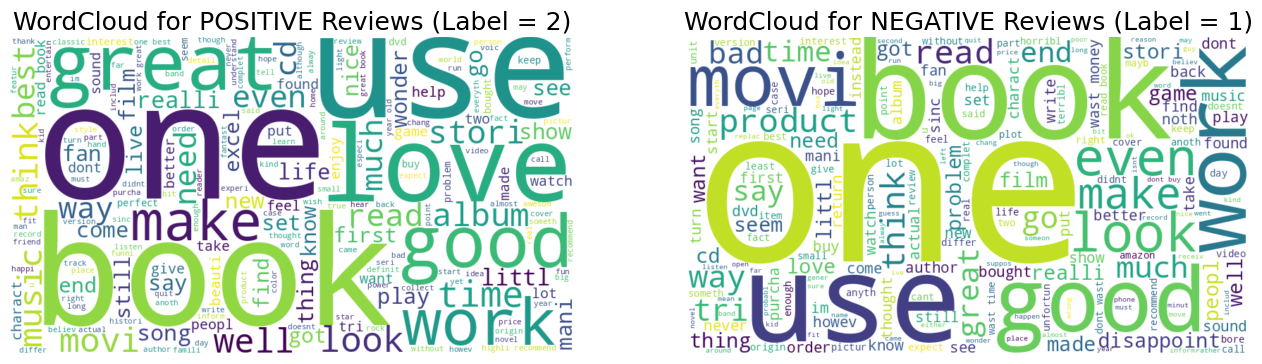

In [32]:

import random # Used for random sampling, ensure it's available or use .sample()

# --- OPTION 1: SAMPLING TO REDUCE RAM CONSUMPTION ---

# Define the maximum number of reviews to sample for the WordCloud creation.
# Adjust this number based on the size of your full dataframe and available RAM.
SAMPLE_SIZE = 50000
# Note: If your dataframe is smaller than 50k, the code will use all available reviews.

# Generate text groups based on correct labels, using a sample
# The .sample() function selects a random subset of reviews, limited by SAMPLE_SIZE.

# Get the positive reviews and sample them
positive_df = train_df[train_df["label"] == "2"]
positive_reviews = " ".join(positive_df["clean_review"].sample(
    n=min(len(positive_df), SAMPLE_SIZE),
    random_state=42 # Set random_state for reproducibility
))

# Get the negative reviews and sample them
negative_df = train_df[train_df["label"] == "1"]
negative_reviews = " ".join(negative_df["clean_review"].sample(
    n=min(len(negative_df), SAMPLE_SIZE),
    random_state=42
))


# Create WordCloud objects
wc_positive = WordCloud(width=800, height=450, background_color="white").generate(positive_reviews)
wc_negative = WordCloud(width=800, height=450, background_color="white").generate(negative_reviews)

# Plot side-by-side WordClouds
plt.figure(figsize=(16,8))

# Positive WordCloud
plt.subplot(1,2,1)
plt.imshow(wc_positive, interpolation="bilinear")
plt.title("WordCloud for POSITIVE Reviews (Label = 2)", fontsize=18)
plt.axis("off")

# Negative WordCloud
plt.subplot(1,2,2)
plt.imshow(wc_negative, interpolation="bilinear")
plt.title("WordCloud for NEGATIVE Reviews (Label = 1)", fontsize=18)
plt.axis("off")

plt.show()

##  **TF-IDF**  
TF-IDF stands for Term Frequency-Inverse Document Frequency. It's a numerical statistic used in natural language processing (NLP) and information retrieval to reflect how important a word is to a document in a collection or corpus.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X_train = train_df["clean_review"]
y_train = train_df["label"]
X_test = test_df["clean_review"]
y_test = test_df["label"] # Assuming 'label' column exists in test_df for evaluation

# 1. Initialize the TfidfVectorizer
# We limit the features to the top 5000 words based on document frequency
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# 2. Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# 3. Transform the test data using the *fitted* vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of TF-IDF matrix (Train):", X_train_tfidf.shape)
print("Shape of TF-IDF matrix (Test):", X_test_tfidf.shape)

Shape of TF-IDF matrix (Train): (3600000, 5000)
Shape of TF-IDF matrix (Test): (400000, 5000)


##  **Model Training**
Three models are selected in this study for training.
1. MultinomialNB (Naive Bayes)
2. Logistic Regression
3. LinearSVC (Support Vector Classification)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import pandas as pd



### 1. Model Training and Prediction ###

# Initialize models
mnb_model = MultinomialNB()
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lsvc_model = LinearSVC(random_state=42, dual='auto') # Note: dual='auto' is recommended

# Train models
print("--- Training Models ---")
mnb_model.fit(X_train_tfidf, y_train)
lr_model.fit(X_train_tfidf, y_train)
lsvc_model.fit(X_train_tfidf, y_train)

# Make predictions (class labels)
y_pred_mnb = mnb_model.predict(X_test_tfidf)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_lsvc = lsvc_model.predict(X_test_tfidf)

# Get probabilities (needed for ROC/AUC, LinearSVC does not provide this easily)
y_proba_mnb = mnb_model.predict_proba(X_test_tfidf)[:, 1]
y_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Store results
models = {
    "MultinomialNB": y_pred_mnb,
    "Logistic Regression": y_pred_lr,
    "LinearSVC": y_pred_lsvc
}

print("\n--- Model Accuracy Scores ---")
for name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

--- Training Models ---


### **Classification report**

In [ ]:
for name, y_pred in models.items():
    print(f"\n--- Classification Report ({name}) ---")
    print(classification_report(y_test, y_pred))

### **Confusion Matrix**

In [ ]:
plt.figure(figsize=(15, 5))
class_labels = sorted(y_test.unique()) # Assumes your labels are 0 and 1, or text labels

for i, (name, y_pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)

    plt.subplot(1, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

### **ROC Curve**

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. Initialize LabelEncoder
# This will convert string labels (e.g., '1', '2') into integers (0, 1)
le = LabelEncoder()

# 2. Fit the encoder and transform the true labels (y_test)
# This creates the necessary binary format (0 or 1) for roc_curve
# Ensure y_test and y_train are consistent if you use this elsewhere
y_test_encoded = le.fit_transform(y_test)

# --- ROC Curve Calculation (Updated) ---
plt.figure(figsize=(7, 6))

# 1. Multinomial Naive Bayes
# Use the encoded y_test
fpr_mnb, tpr_mnb, _ = roc_curve(y_test_encoded, y_proba_mnb)
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)
plt.plot(fpr_mnb, tpr_mnb, color='darkorange', lw=2,
         label=f'MNB ROC curve (area = {roc_auc_mnb:.4f})')

# 2. Logistic Regression
# Use the encoded y_test
fpr_lr, tpr_lr, _ = roc_curve(y_test_encoded, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='green', lw=2,
         label=f'LR ROC curve (area = {roc_auc_lr:.4f})')

# 3. Random baseline
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()